Buscamos crear una nueva columna de categorias que tenga un menor numero para que el usuario no tenga que elegir entre miles, sino unas pocas.

In [28]:
# Importamos para cargar la data
import polars as pl

# Para cargar los embeedings
import spacy

In [3]:
# Cargamos la data
business = pl.read_parquet('../../data/yelp/production/business.parquet')

In [6]:
# Cuantas filas con valores unicos hay en categories
business['categories'].unique().shape[0]

83144

In [40]:
# Construimos conjunto de categorias

# Concatenamos todas las filas con la coma
corpus = business['categories'].str.concat(',')[0]
# Convertimos el texto a lista y eliminamos los espacios al inicio y al final
corpus = [category.strip() for category in corpus.split(',')]
# Eliminamos duplicados y convertimos a lista para poder indexar.
categories = list(set(corpus))

# El numero de categorias es
len(categories)

1312

In [30]:
# Cargamos el modelo con el embeeding
nlp = spacy.load('en_core_web_lg')

In [41]:
# categ2vec es un diccionario de la forma key (categoria) : value (vector)
categ2vec = {}
for categ in categories:
    vector = nlp(categ).vector
    categ2vec[categ] = vector

In [107]:
# Importamos la libreria para crear los clusteres
from sklearn.cluster import KMeans

# Cargamos la funcion de similitud para evaluar los clusteres
from sklearn.metrics.pairwise import cosine_similarity

# Importamos numpy para trabajar con matrices
import numpy as np

In [108]:
# Se crea una matriz donde cada fila es el vector de las categoria.
data = np.vstack(list(categ2vec.values()))
# Se computa la matriz de similitud, por lo que es de 1312 x 1312
sim_data = cosine_similarity(data)

# Numero de filas/columnas
data.shape, sim_data.shape

((1312, 300), (1312, 1312))

In [42]:
# Funcion que utilizamos para evaluar el numero de cluster
def mean_similarity(index):
    # medida de cohesion o similitud.
    output = []
    for i in range(len(index)):
        for j in range(i+1, len(index)):
            similarity = sim_data[index[i], index[j]]
            output.append(similarity)
    return np.mean(output)

In [116]:
# Lista que contendra el valor de la metrica para el numero de cluster dados
metrics = []
for i in range(5, 30):
    # Creamos el modelo con los parametros determinados
    model = KMeans(n_clusters=i, random_state=2023, n_init=5, init='k-means++')
    # Entrenamos el modelo y obtenemos los labels
    model.fit(data)
    cluster_labels = model.labels_

    # Agrupamos las categorias en los grupos correspondientes
    group = {}
    sim_by_group = []
    for label in set(cluster_labels):
        if label == -1:
            continue
        index = np.where(cluster_labels == label)[0]
        elements = [categories[i] for i in index]
        group[label] = elements
        sim_by_group.append(len(index) * mean_similarity(index))
    metrics.append(np.sum(sim_by_group) / len(cluster_labels))

# Esta lista contiene la variacion en la metrica
variacion = []
for i in range(1, len(metrics)):
    value = np.round((metrics[i] - metrics[i - 1]) / metrics[i - 1], 3)
    variacion.append(value)

In [46]:
# Importamos la libreria para poder graficar la matrica
import matplotlib.pyplot as plt

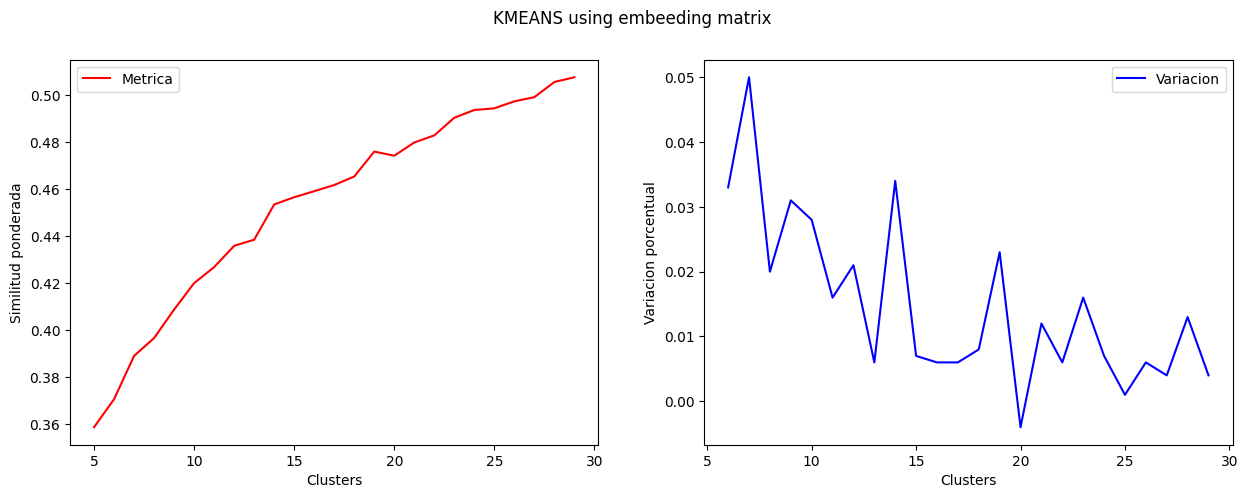

In [117]:
# Graficamos la metrica y la variacion.

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(range(5, 30), metrics, color='r', label='Metrica')
ax[1].plot(range(6, 30), variacion, color='b', label='Variacion')

fig.suptitle('KMEANS using embeeding matrix')
ax[0].set_xlabel('Clusters')
ax[1].set_xlabel('Clusters')

ax[0].set_ylabel('Similitud ponderada')
ax[1].set_ylabel('Variacion porcentual')

ax[0].legend()
ax[1].legend()

# fig.savefig('kmeans_v1')
plt.show()

In [122]:
# Elegimos el numero de cluster que vamos a usar basandonos en el grafico de arriba
# Y printamos unos ejemplos para ver como son.

model = KMeans(n_clusters=14, random_state=2023, init='k-means++', n_init=5)
model.fit(data)
cluster_labels = model.labels_

group = {}

for label in set(cluster_labels):
    if label == -1:
        continue
    index = np.where(cluster_labels == label)[0]
    elements = [categories[i] for i in index]
    print(f'Group {label}: {elements[0:5]}')
    group[str(label)] = elements

Group 0: ['naturopathic/holistic', 'heating & air conditioning/hvac', 'audio/visual equipment rental', 'atv rentals/tours', 'gun/rifle ranges']
Group 1: ['ski schools', 'tours', 'mobile home parks', 'oxygen bars', 'drive-thru bars']
Group 2: ['windshield installation & repair', 'public services & government', 'motorcycle parts & supplies', 'coffee & tea', 'couriers & delivery services']
Group 3: ['caricatures', 'fencing clubs', 'supernatural readings', 'calligraphy', 'martial arts']
Group 4: ['physical therapy', 'internal medicine', 'elder care planning', 'foot care', 'orthodontists']
Group 5: ['taiwanese', 'malaysian', 'thai', 'pan asian', 'vietnamese']
Group 6: ['homeless shelters', 'homeowner association', 'courthouses', 'mortgage lenders', 'walk-in clinics']
Group 7: ['watches', 'shoe shine', 'shutters', 'solar installation', 'grilling equipment']
Group 8: ['hearing aid providers', 'mortuary services', 'reproductive health services', 'pet cremation services', 'health insurance offi

In [127]:
# Aqui creamos las etiquetas con las que agruparemos cada una de las viejas categorias.

new_labels = ["healthcare services", "recreational activities", "public services and government", "arts and culture", "medical services",
              "international cuisine", "community services", "home services", "health and wellness services", "rental and repair services",
              "food and groceries", "legal services", "international cuisine", "pet services"]
new_labels = {str(key):label for key, label in enumerate(new_labels)}

new_group = {}
for key, value in group.items():
    label = new_labels[key]
    if label not in new_group:
        new_group[label] = value
    else:
        new_group[label].extend(value)

In [136]:
# Toca crear una nueva columna tal que tenga la etiqueta correspondiente segun el grupo al que pertenezca.
# Esta funcion hace lo de arriba
def add_label(categories):
    try:
        categories = [x.strip() for x in categories.split(',')]
    except:
        return None
    for category in categories:
        for key, value in new_group.items():
            if category in value:
                return key

In [141]:
# Creamos la nueva columna llamada agg_categories
business = business.with_columns(pl.col('categories').apply(add_label).alias('agg_categories'))

In [219]:
# Obtenemos la distribucion de datos para imputar los valores faltantes
counts = business.filter(pl.col('agg_categories').is_not_null())['agg_categories'].value_counts()['counts'].to_list()
# Y las etiquetas
labels = business.filter(pl.col('agg_categories').is_not_null())['agg_categories'].value_counts()['agg_categories'].to_list()

# Array de probabilidad
prob = np.array(counts)/np.sum(counts)

def get_random_labels(value, labels=labels, prob=prob):
    return np.random.choice(labels, size=1, p=prob)[0]

def fillna_partial_solution(value, function=get_random_labels):
    if value is not None:
        return value
    else:
        return function(value)

In [243]:
# Hacemos todo esto porque polars nos la pone re dificil compaaa
df = business.to_pandas()
df['agg_categories'] = df['agg_categories'].apply(fillna_partial_solution)
business = pl.from_pandas(df)

In [256]:
# Almacenamos en formato parquet para reducir espacio.
business.write_parquet('../../data/yelp/production/business.parquet')